tourne avec l'environnement py310_data_analysis2
# Relations réciproques entres personnes et avec les institutions

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itables import init_notebook_mode, show
import numpy as np
import seaborn as sns
from netgraph import Graph, InteractiveGraph
from pyvis.network import Network

## Production des données

* Requête exécutée sur le serveur https://dbpedia.org/sparql 
* Période élargie jusqu'aux comtemporains-nes
* Propriétés prises en compte après inspection des propriétés de la population:
  * http://dbpedia.org/ontology/almaMater 
  * http://dbpedia.org/ontology/institution


```SPARQL
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
SELECT DISTINCT (?o1 AS ?subject_uri) ?subjectBirthDate ?r_property  ?target 
# (COUNT(*) AS ?effectif) 
WHERE {
  SELECT DISTINCT ?o1 ?subjectBirthDate ?r_property  ?target 
  WHERE { 
    {
          {dbr:List_of_archaeologists ?p ?o1.}
      UNION
          {?o1 ?p dbr:archaeologists.}
      UNION
          {?o1 ?p dbr:archaeology.}
      UNION
         {?o1 ?p dbr:antiquarian.}
    }
    ?o1 a dbo:Person;
      dbp:birthDate | dbo:birthDate ?subjectBirthDate.
     {
        {?o1 dbo:almaMater ?target.
     BIND('almaMater' AS ?r_property) }
UNION  {?o1 dbo:institution ?target.
     BIND('institution' AS ?r_property) }
#UNION  {?o1 dbp:fields ?target.
#     BIND('fields' AS ?r_property) }
#UNION  {?o1 dbp:field ?target.
#     BIND('field' AS ?r_property) }
}

    BIND(xsd:integer(SUBSTR(STR(?subjectBirthDate), 1, 4)) AS ?birthYear)
    FILTER ( (?birthYear >= 1401   ))
 
          }
  ORDER BY ?birthYear
  }

```

In [2]:
### Ouvrir le fichier et créer un DataFrame
fd = 'data/dbpedia_archeologue_institutions.csv'
df = pd.read_csv(fd)
len(df)

239

In [3]:
### Raccourcir l'URI, extraire l'année de naissance
df['subject_uri'] = df['subject_uri'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
df['target'] = df['target'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
df['BirthYear'] = df['subjectBirthDate'].apply(lambda x : int(x[:4]))

In [4]:
### Ajouter deux périodes différentes en fonctions de la relation
# Pour la relation 'étudier' créer une période entre 18 et 28 ans (+17, +27) pour l'étendue des études
# Pour la relation 'insitution' ajouté une période d'activité de 19 à 65 ans
df['YBegin'] = df[['BirthYear', 'r_property']].apply(lambda x : int(x['BirthYear'] + 17) if x['r_property'] == 'almaMater' else int(x['BirthYear'] + 27), axis=1)
df['YEnd'] = df[['BirthYear', 'r_property']].apply(lambda x : int(x['BirthYear'] + 28) if x['r_property'] == 'almaMater' else int(x['BirthYear'] + 64), axis=1)

In [5]:
### Inspecter DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subject_uri       239 non-null    object
 1   subjectBirthDate  239 non-null    object
 2   r_property        239 non-null    object
 3   target            239 non-null    object
 4   BirthYear         239 non-null    int64 
 5   YBegin            239 non-null    int64 
 6   YEnd              239 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 13.2+ KB


In [6]:
### Inspecter la distribution des années de naissance
df.BirthYear.describe()

count     239.000000
mean     1925.138075
std        36.411308
min      1717.000000
25%      1909.000000
50%      1936.000000
75%      1948.000000
max      1972.000000
Name: BirthYear, dtype: float64

In [7]:
### Inspecter la table 
# https://github.com/mwouts/itables/blob/main/docs/advanced_parameters.md
show(df[['subject_uri','r_property','target','YBegin','YEnd','BirthYear']].sort_values(by='BirthYear'), classes="display", scrollY="200px", 
     scrollCollapse=True, paging=False, column_filters="footer", dom="lrtip")

In [8]:
### Compter par propriété
df.groupby(by='r_property').size()

r_property
almaMater      166
institution     73
dtype: int64

In [9]:
### Effectuer et documenter tous les changements: nettoyage des données
df.loc[df.target == 'École_normale_supérieure_(Ulm)', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_normale_supérieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_Normale_Supérieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_Normale_Superieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'University_College_London', 'target']  = 'University_of_London'

In [10]:
### Remplacements multiples
df.loc[(df.target.str.contains('Paris')) & (df.target.str.contains('Univ')), 'target'] = "Université_de_Paris"
df.loc[(df.target.str.contains('Oxford')) & (df.target.str.contains('College')), 'target'] = "University_of_Oxford"
df.loc[(df.target.str.contains('Cambridge')) & (df.target.str.contains('College')), 'target'] = "University_of_Cambridge"


In [11]:
organisations = df.groupby(by='target').size()
show(organisations.sort_index(ascending=False))

In [12]:
### Effectif total et les plus représentées
len(organisations), organisations.sort_values(ascending=False).head(10)

(152,
 target
 University_of_Cambridge       14
 University_of_London          10
 University_of_Michigan        10
 University_of_Oxford           9
 University_of_Chicago          6
 Harvard_University             6
 Columbia_University            4
 University_of_Pennsylvania     4
 University_of_Cape_Town        4
 University_of_Tehran           4
 dtype: int64)

### Explorer les années de naissance

In [13]:
s = df.BirthYear

(1846.0, 1972.0)

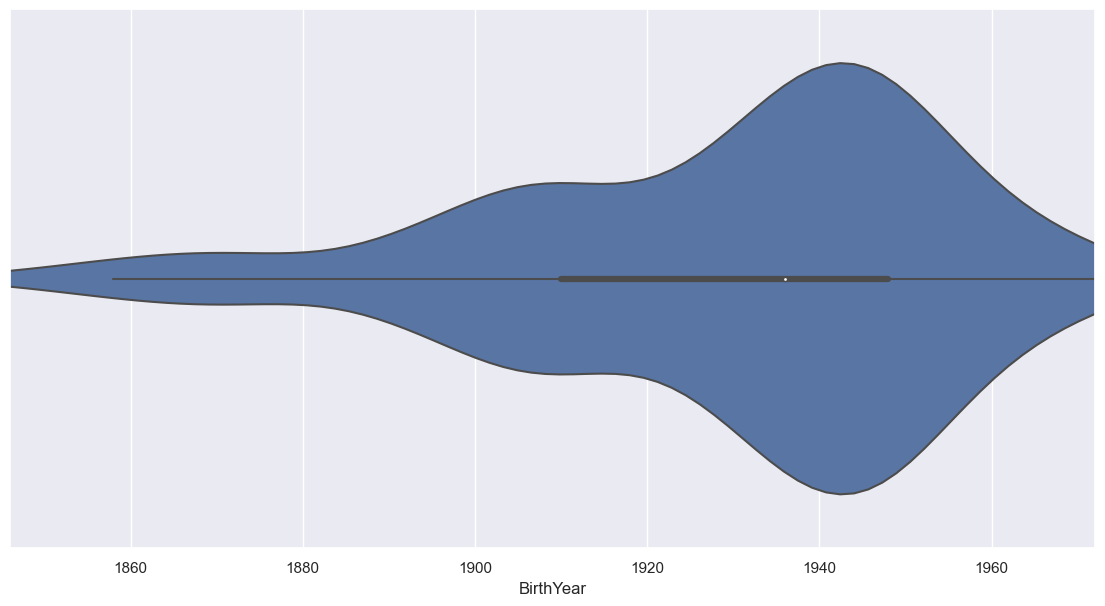

In [14]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(14, 7)})

## Période pré-scientifique
# a = s[(s<1801)]
## Décollage de la science 'moderne'
a = s[(s>1800) & (s<2001)] # 
## Science contemporaine
# a = s[(s>1900) ] # 
lim_left=min(a)
lim_right=max(a)





ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=lim_left, right=lim_right)


#### Coder les périodes

In [15]:
bins=[1001,1801,1901,2021]

In [16]:
df['periode'] = pd.cut(df['BirthYear'], bins=bins, right=False  )
df.periode = df.periode.apply( lambda x : str(x.left) + '_' + str(x.right))

In [17]:
df.head()

,subject_uri,subjectBirthDate,r_property,target,BirthYear,YBegin,YEnd,periode
0,Johann_Joachim_Winckelmann,1717-12-09,almaMater,University_of_Halle,1717,1734,1745,1001_1801
1,Christian_Gottlob_Heyne,1729-09-25,almaMater,Leipzig_University,1729,1746,1757,1001_1801
2,Thomas_Jefferson,1743-04-13,almaMater,College_of_William_&_Mary,1743,1760,1771,1001_1801
3,Jean-François_Champollion,1790-12-23,almaMater,Collège_de_France,1790,1807,1818,1001_1801
4,Jean-François_Champollion,1790-12-23,almaMater,Institut_national_des_langues_et_civilisations...,1790,1807,1818,1001_1801


In [18]:
### Effectif par période
df.groupby(by='periode').size()

periode
1001_1801      5
1801_1901     33
1901_2021    201
dtype: int64

In [19]:
### Dataframe to dictionary
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html
ldf = df[['subject_uri', 'r_property', 'target',
       'YBegin', 'YEnd', 'BirthYear', 'periode']].sort_values(by='subject_uri').to_dict('records')

In [20]:
ldf[:2]

[{'subject_uri': 'Ahmad_Hasan_Dani',
  'r_property': 'almaMater',
  'target': 'Banaras_Hindu_University',
  'YBegin': 1937,
  'YEnd': 1948,
  'BirthYear': 1920,
  'periode': '1901_2021'},
 {'subject_uri': 'Aileen_Fox',
  'r_property': 'almaMater',
  'target': 'University_of_Cambridge',
  'YBegin': 1924,
  'YEnd': 1935,
  'BirthYear': 1907,
  'periode': '1901_2021'}]

## Graphe à deux types de sommets


Il s'agit d'un graphe de type 'bipartite', cf. la documentation de Networkx:

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html

Nous n'utilisons toutefois pas ici les fonctions spécifiques de Neworkx.

In [21]:
l = []
for i in ldf:
    if i['periode'] == '1901_2021':
        l.append(tuple((i['subject_uri'],i['target'], 
                        {'relationship': i['r_property'], "birth_year": i['BirthYear'], "periode": i['periode'] })))
l[:5]

[('Ahmad_Hasan_Dani',
  'Banaras_Hindu_University',
  {'relationship': 'almaMater', 'birth_year': 1920, 'periode': '1901_2021'}),
 ('Aileen_Fox',
  'University_of_Cambridge',
  {'relationship': 'almaMater', 'birth_year': 1907, 'periode': '1901_2021'}),
 ('Alice_Kober',
  'Columbia_University',
  {'relationship': 'almaMater', 'birth_year': 1906, 'periode': '1901_2021'}),
 ('Alice_Kober',
  'Hunter_College',
  {'relationship': 'almaMater', 'birth_year': 1906, 'periode': '1901_2021'}),
 ('Alice_Kober',
  'Doctor_of_Philosophy',
  {'relationship': 'almaMater', 'birth_year': 1906, 'periode': '1901_2021'})]

In [22]:
# Graphe Personne- Organisation
POG=nx.Graph()

In [23]:
POG.add_edges_from(l)

In [24]:
### Principales caractéristiques de ce graphe

POG.is_multigraph(), POG.is_directed(), nx.is_connected(POG), POG.number_of_nodes(), POG.number_of_edges(), nx.density(POG)


(False, False, False, 215, 191, 0.00830254292545099)

In [25]:
### Créer une liste des organisations
l_org = list(organisations.index); len(l_org); l_org[:3]

['Accademia_di_Belle_Arti_di_Venezia',
 'Albion_College',
 'Alexandria_University']

In [26]:
list(POG.nodes.data())[:4]

[('Ahmad_Hasan_Dani', {}),
 ('Banaras_Hindu_University', {}),
 ('Aileen_Fox', {}),
 ('University_of_Cambridge', {})]

In [27]:
### Ajouter au sommets un code si personne ou organisation
# On utiliser pour ce faire la liste des organisations
types = {}
for e in list(POG.nodes):
    if e in l_org:
        t = 'O'
    else:
        t = 'P'
    types[e] = {'type': t} 
[(k,v )for k,v in types.items()][:3]  

[('Ahmad_Hasan_Dani', {'type': 'P'}),
 ('Banaras_Hindu_University', {'type': 'O'}),
 ('Aileen_Fox', {'type': 'P'})]

In [28]:
nx.set_node_attributes(POG, types)
list(POG.nodes.data())[:3]

[('Ahmad_Hasan_Dani', {'type': 'P'}),
 ('Banaras_Hindu_University', {'type': 'O'}),
 ('Aileen_Fox', {'type': 'P'})]

### Inspecter les centralités de degré

In [29]:
### Ajouter la centralité de degré
# grâce à un dictionnaire construit selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(POG)])

In [30]:
nx.set_node_attributes(POG, degree)

In [31]:
print(list(POG.nodes.data())[:4])

[('Ahmad_Hasan_Dani', {'type': 'P', 'degree': 1}), ('Banaras_Hindu_University', {'type': 'O', 'degree': 1}), ('Aileen_Fox', {'type': 'P', 'degree': 1}), ('University_of_Cambridge', {'type': 'O', 'degree': 11})]


In [32]:
persons_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'P':
        persons_degree.append([n[0], n[1]['degree']])

In [33]:
sorted(persons_degree, key = lambda x : x[1], reverse=True)[:10]

[['Lewis_Binford', 6],
 ['Richard_Klein_(paleoanthropologist)', 6],
 ['Alireza_Shapour_Shahbazi', 5],
 ['Betty_Meggers', 5],
 ['David_L._Kennedy', 5],
 ['Ian_Hodder', 5],
 ['Janette_Deacon', 5],
 ['Birgitta_Hoffmann', 4],
 ['Carmel_Schrire', 4],
 ['Dolores_Piperno', 4]]

In [34]:
org_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'O':
        org_degree.append([n[0], n[1]['degree']])

In [35]:
sorted(org_degree, key = lambda x : x[1], reverse=True)[:10]

[['University_of_Cambridge', 11],
 ['University_of_London', 8],
 ['University_of_Michigan', 8],
 ['Harvard_University', 5],
 ['University_of_Chicago', 5],
 ['Columbia_University', 4],
 ['University_of_Pennsylvania', 4],
 ['University_of_Cape_Town', 4],
 ['University_of_Tehran', 3],
 ['University_of_Oxford', 3]]

In [36]:
edges = list(POG.edges.data())
edges[:5]

[('Ahmad_Hasan_Dani',
  'Banaras_Hindu_University',
  {'relationship': 'almaMater', 'birth_year': 1920, 'periode': '1901_2021'}),
 ('Aileen_Fox',
  'University_of_Cambridge',
  {'relationship': 'almaMater', 'birth_year': 1907, 'periode': '1901_2021'}),
 ('University_of_Cambridge',
  'Andrew_Sherratt',
  {'relationship': 'almaMater', 'birth_year': 1946, 'periode': '1901_2021'}),
 ('University_of_Cambridge',
  'Carmel_Schrire',
  {'relationship': 'almaMater', 'birth_year': 1941, 'periode': '1901_2021'}),
 ('University_of_Cambridge',
  'Colin_Renfrew',
  {'relationship': 'almaMater', 'birth_year': 1937, 'periode': '1901_2021'})]

In [37]:
labels = {}    
for node in POG.nodes():
    labels[node] = node

In [38]:
nx.set_node_attributes(POG, labels, 'label')

In [39]:
nodes = list(POG.nodes.data())
nodes[:5]

[('Ahmad_Hasan_Dani', {'type': 'P', 'degree': 1, 'label': 'Ahmad_Hasan_Dani'}),
 ('Banaras_Hindu_University',
  {'type': 'O', 'degree': 1, 'label': 'Banaras_Hindu_University'}),
 ('Aileen_Fox', {'type': 'P', 'degree': 1, 'label': 'Aileen_Fox'}),
 ('University_of_Cambridge',
  {'type': 'O', 'degree': 11, 'label': 'University_of_Cambridge'}),
 ('Alice_Kober', {'type': 'P', 'degree': 3, 'label': 'Alice_Kober'})]

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [40]:
components = nx.connected_components(POG);
components_l = [len(c) for c in sorted(nx.connected_components(POG), key=len, reverse=True)]
len(components_l), components_l[:5]

(36, [117, 8, 6, 5, 4])

In [41]:
S = [POG.subgraph(c).copy() for c in nx.connected_components(POG)]

In [42]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[1, 117], [4, 8], [9, 6], [7, 5], [26, 4], [27, 4], [30, 4], [3, 3]]

In [43]:
li=[n[0] for n in ln]

In [44]:
S[21].nodes 

NodeView(('Vilnius_University', 'Marija_Gimbutas'))

### Représenter le graphe

In [45]:
u = S[14]

In [46]:
u = nx.Graph()
for i in li[:5]:
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [47]:
### Principales caractéristiques de ce graphe

u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


(False, False, 140, 147, 0.015107913669064749)

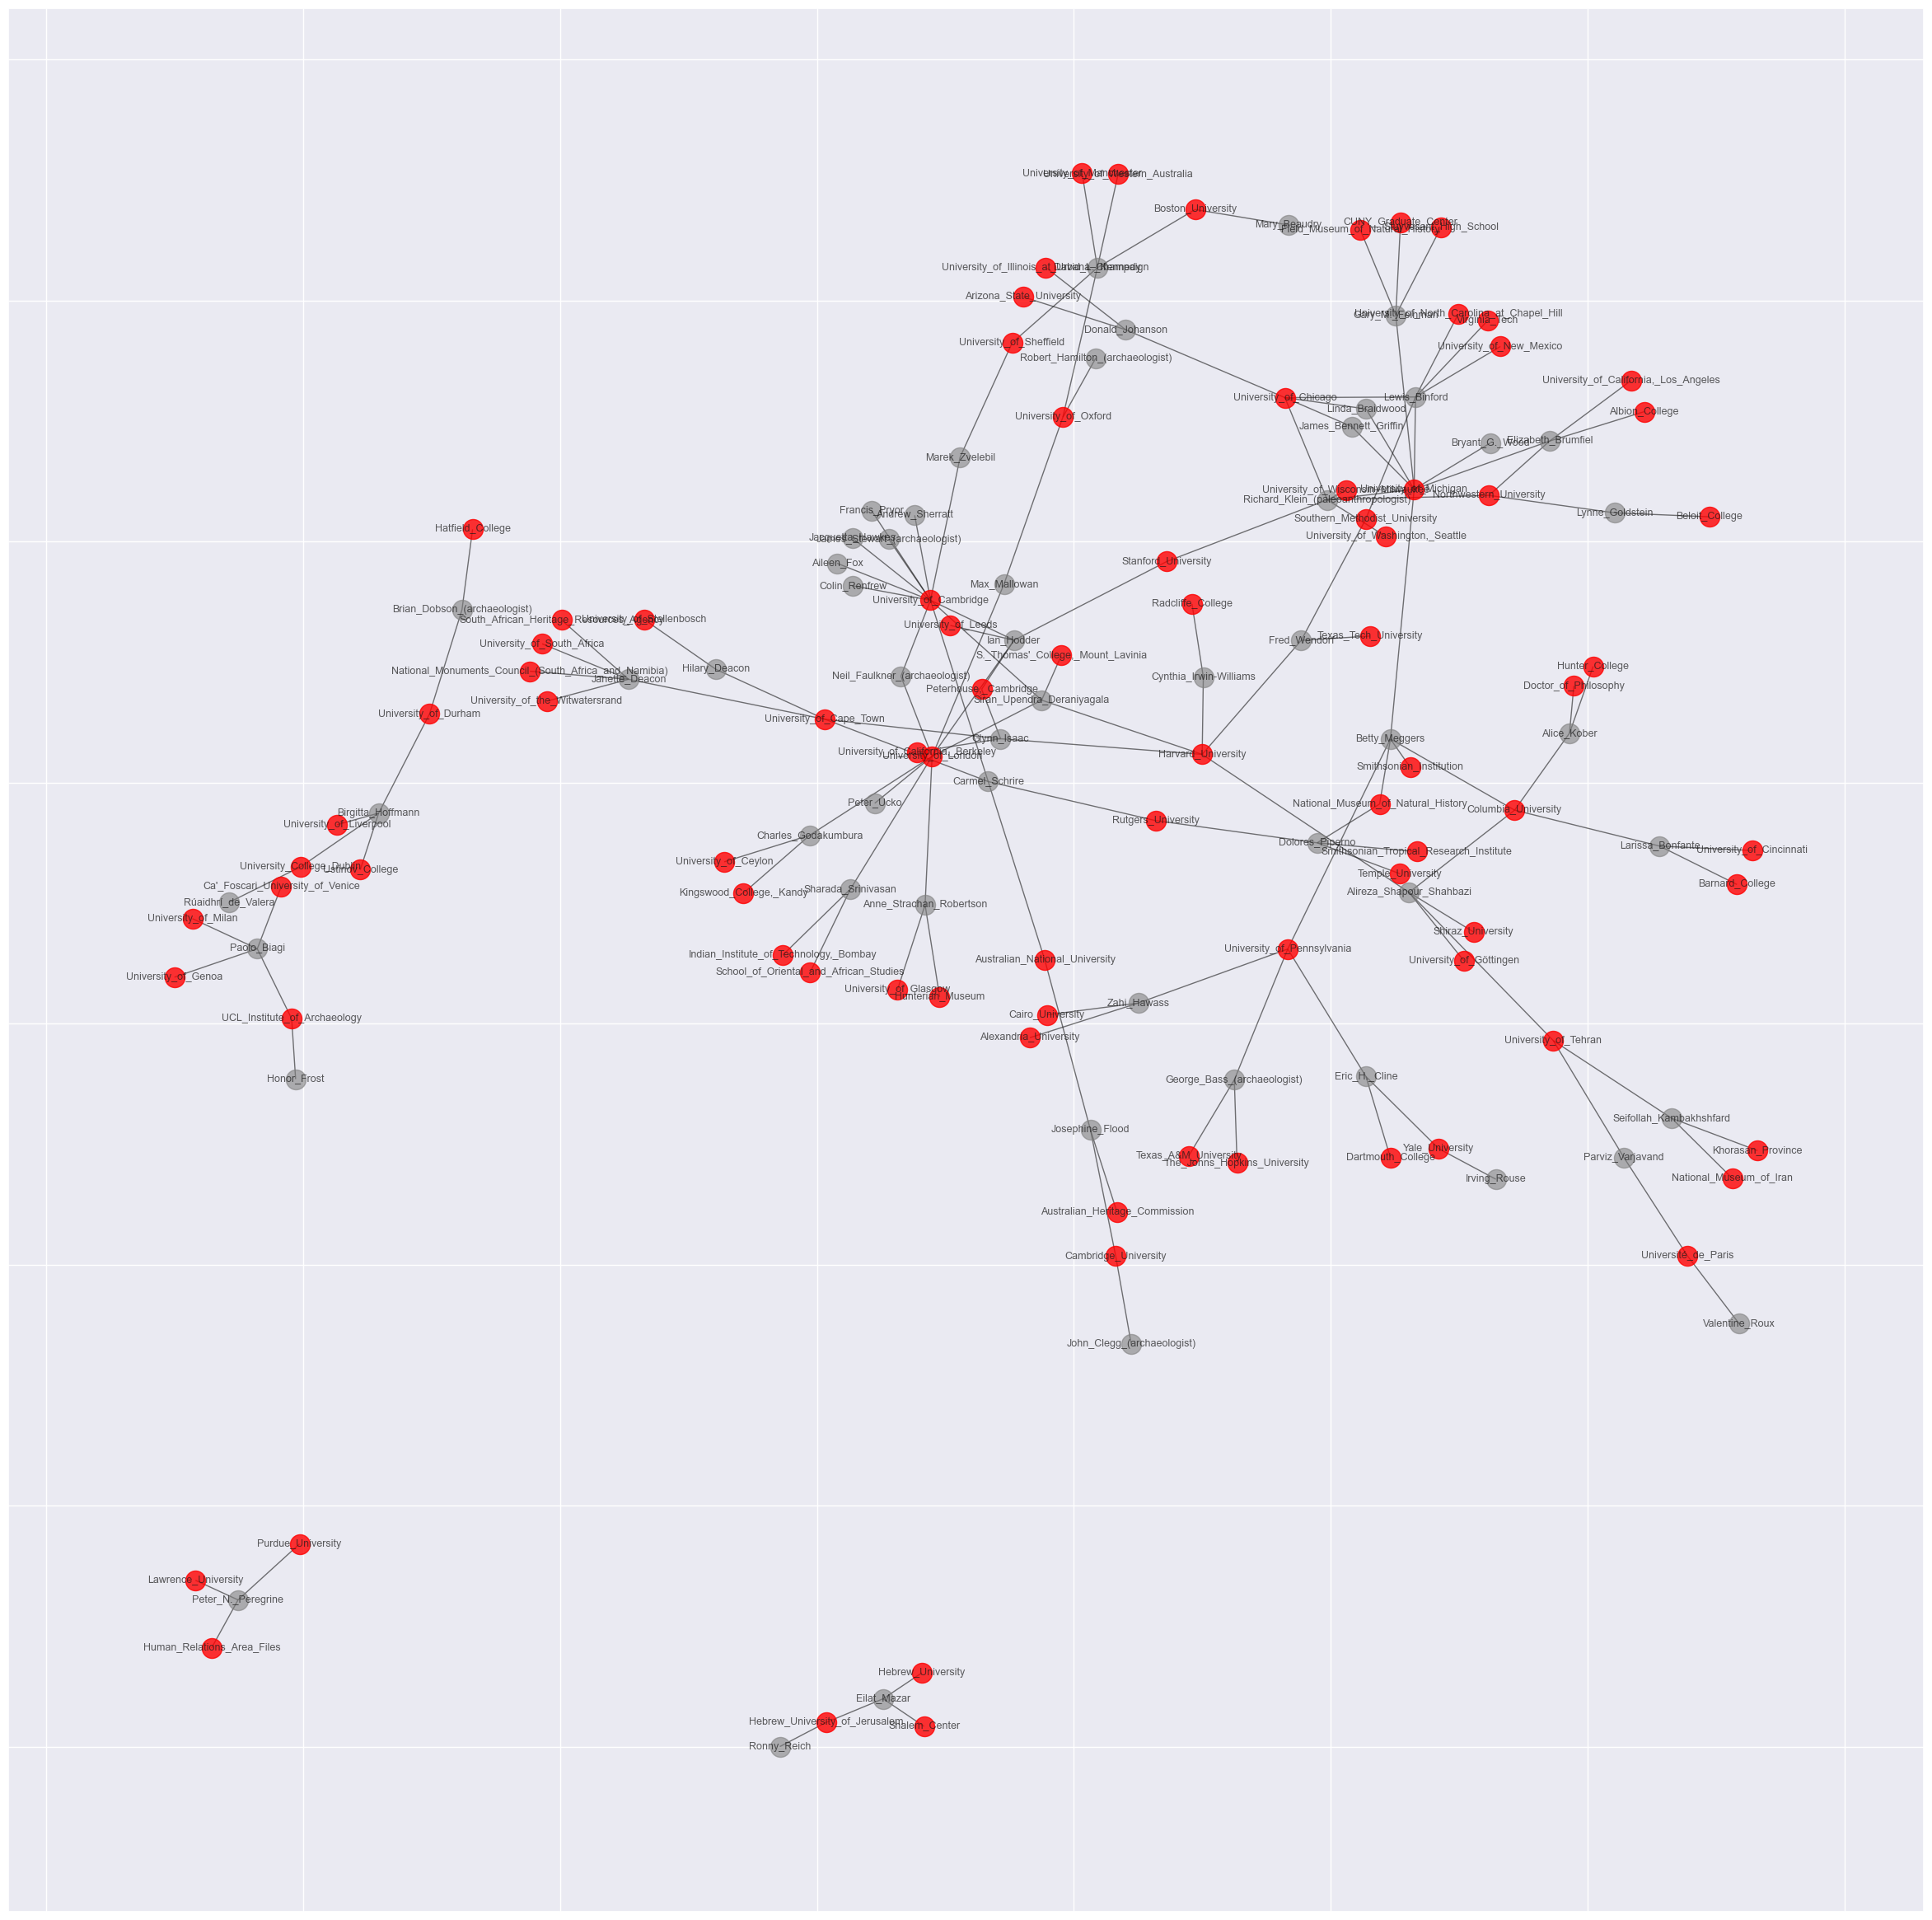

In [48]:
### Visualiser les "écoles", i.e. quelles personnes 
# ont étudié dans la même Université
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

g = u

pos = nx.spring_layout(g)

no = [x for x,y in g.nodes(data=True) if y['type']=='O']
np = [x for x,y in g.nodes(data=True) if y['type']=='P'] 

co = 'red'
cp = 'grey'
nx.draw_networkx_nodes(g, pos, nodelist=np, node_color=cp, alpha=0.6)
nx.draw_networkx_nodes(g, pos, nodelist=no, node_color=co, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6)
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=9)


plt.show()


In [49]:
nt = Network( notebook=True) #, filter_menu=True)
# populates the nodes and edges data structures
nt.from_nx(g)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [50]:
nt.prep_notebook()
nt.show('pictures/nx.html' )

### Créer les paires de personnes

Personnes ayant étudié dans la même univerisité, à la même époque:

* on teste si c'est la même université
* on teste s'il y a superposition des périodes

In [51]:
pairs_p = []

for s1 in ldf:
    for s2 in ldf:
        if s1['subject_uri'] < s2['subject_uri'] \
            and s1['target'] == s2['target'] \
            and s2['YEnd'] > s1['YBegin'] \
            and s2['YBegin'] < s1['YEnd']:
            pairs_p.append([s1,s2])
        else:
            pass

In [52]:
len(pairs_p)

93

In [53]:
pairs_p[:2]

[[{'subject_uri': 'Aileen_Fox',
   'r_property': 'almaMater',
   'target': 'University_of_Cambridge',
   'YBegin': 1924,
   'YEnd': 1935,
   'BirthYear': 1907,
   'periode': '1901_2021'},
  {'subject_uri': 'Jacquetta_Hawkes',
   'r_property': 'almaMater',
   'target': 'University_of_Cambridge',
   'YBegin': 1927,
   'YEnd': 1938,
   'BirthYear': 1910,
   'periode': '1901_2021'}],
 [{'subject_uri': 'Aileen_Fox',
   'r_property': 'almaMater',
   'target': 'University_of_Cambridge',
   'YBegin': 1924,
   'YEnd': 1935,
   'BirthYear': 1907,
   'periode': '1901_2021'},
  {'subject_uri': 'James_Stewart_(archaeologist)',
   'r_property': 'almaMater',
   'target': 'University_of_Cambridge',
   'YBegin': 1930,
   'YEnd': 1941,
   'BirthYear': 1913,
   'periode': '1901_2021'}]]

### Créer les pairs d'organisations

Une personne fait le lien entre deux organisations

In [54]:
pairs_o = []

for s1 in ldf:
    for s2 in ldf:
        if s1['target'] < s2['target'] \
            and s1['subject_uri'] == s2['subject_uri']:
                pairs_o.append([s1,s2])
        else:
            pass

In [55]:
len(pairs_o)

228

In [56]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'subject_uri': 'Alice_Kober',
   'r_property': 'almaMater',
   'target': 'Columbia_University',
   'YBegin': 1923,
   'YEnd': 1934,
   'BirthYear': 1906,
   'periode': '1901_2021'},
  {'subject_uri': 'Alice_Kober',
   'r_property': 'almaMater',
   'target': 'Hunter_College',
   'YBegin': 1923,
   'YEnd': 1934,
   'BirthYear': 1906,
   'periode': '1901_2021'}],
 [{'subject_uri': 'Alice_Kober',
   'r_property': 'almaMater',
   'target': 'Columbia_University',
   'YBegin': 1923,
   'YEnd': 1934,
   'BirthYear': 1906,
   'periode': '1901_2021'},
  {'subject_uri': 'Alice_Kober',
   'r_property': 'almaMater',
   'target': 'Doctor_of_Philosophy',
   'YBegin': 1923,
   'YEnd': 1934,
   'BirthYear': 1906,
   'periode': '1901_2021'}]]

## Réseaux de personnes (filtres, sous-populations)

In [57]:
Modern_pairs = [p for p in pairs_p if ((p[0]['periode']=='1901_2021') & (p[1]['periode']=='1901_2021'))]

In [58]:
len(Modern_pairs), Modern_pairs[:3]

(87,
 [[{'subject_uri': 'Aileen_Fox',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1924,
    'YEnd': 1935,
    'BirthYear': 1907,
    'periode': '1901_2021'},
   {'subject_uri': 'Jacquetta_Hawkes',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1927,
    'YEnd': 1938,
    'BirthYear': 1910,
    'periode': '1901_2021'}],
  [{'subject_uri': 'Aileen_Fox',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1924,
    'YEnd': 1935,
    'BirthYear': 1907,
    'periode': '1901_2021'},
   {'subject_uri': 'James_Stewart_(archaeologist)',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1930,
    'YEnd': 1941,
    'BirthYear': 1913,
    'periode': '1901_2021'}],
  [{'subject_uri': 'Alireza_Shapour_Shahbazi',
    'r_property': 'institution',
    'target': 'Harvard_University',
    'YBegin': 1969,
    'YEnd': 2006,
    'BirthYear': 1942,
    'period

In [59]:
almaMater_pairs = [p for p in pairs_p if ((p[0]['r_property'] == 'almaMater') & (p[1]['r_property'] == 'almaMater'))]

In [60]:
len(almaMater_pairs), almaMater_pairs[:2]

(54,
 [[{'subject_uri': 'Aileen_Fox',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1924,
    'YEnd': 1935,
    'BirthYear': 1907,
    'periode': '1901_2021'},
   {'subject_uri': 'Jacquetta_Hawkes',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1927,
    'YEnd': 1938,
    'BirthYear': 1910,
    'periode': '1901_2021'}],
  [{'subject_uri': 'Aileen_Fox',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1924,
    'YEnd': 1935,
    'BirthYear': 1907,
    'periode': '1901_2021'},
   {'subject_uri': 'James_Stewart_(archaeologist)',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1930,
    'YEnd': 1941,
    'BirthYear': 1913,
    'periode': '1901_2021'}]])

## Exploration des graphes de personnes

In [61]:
### Préparer pour créer le graphe
l = []
for i in Modern_pairs: #almaMater_pairs:
    l.append(tuple((i[0]['subject_uri'],i[1]['subject_uri'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}", 
                                                              'organisation': i[0]['target'] })))
l[:5]

[('Aileen_Fox',
  'Jacquetta_Hawkes',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Cambridge'}),
 ('Aileen_Fox',
  'James_Stewart_(archaeologist)',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Cambridge'}),
 ('Alireza_Shapour_Shahbazi',
  'Glynn_Isaac',
  {'relationship': 'institution_institution',
   'organisation': 'Harvard_University'}),
 ('Alireza_Shapour_Shahbazi',
  'Siran_Upendra_Deraniyagala',
  {'relationship': 'institution_almaMater',
   'organisation': 'Harvard_University'}),
 ('Alireza_Shapour_Shahbazi',
  'Seifollah_Kambakhshfard',
  {'relationship': 'institution_institution',
   'organisation': 'University_of_Tehran'})]

In [62]:
EMP=nx.Graph()

In [63]:
EMP.add_edges_from(l)

In [64]:
### Principales caractéristiques de ce graphe

EMP.is_multigraph(), EMP.is_directed(), nx.is_connected(EMP), EMP.number_of_nodes(), EMP.number_of_edges(), nx.density(EMP)


(False, False, False, 49, 75, 0.06377551020408163)

In [65]:
nodes = list(EMP.nodes.data())
nodes[:5]

[('Aileen_Fox', {}),
 ('Jacquetta_Hawkes', {}),
 ('James_Stewart_(archaeologist)', {}),
 ('Alireza_Shapour_Shahbazi', {}),
 ('Glynn_Isaac', {})]

In [66]:
edges = list(EMP.edges.data())
edges[:5]

[('Aileen_Fox',
  'Jacquetta_Hawkes',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Cambridge'}),
 ('Aileen_Fox',
  'James_Stewart_(archaeologist)',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Cambridge'}),
 ('Jacquetta_Hawkes',
  'James_Stewart_(archaeologist)',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Cambridge'}),
 ('Alireza_Shapour_Shahbazi',
  'Glynn_Isaac',
  {'relationship': 'institution_institution',
   'organisation': 'Harvard_University'}),
 ('Alireza_Shapour_Shahbazi',
  'Siran_Upendra_Deraniyagala',
  {'relationship': 'institution_almaMater',
   'organisation': 'Harvard_University'})]

In [67]:
labels = {}    
for node in EMP.nodes():
    labels[node] = node

In [68]:
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
nt = Network( notebook=True)
# populates the nodes and edges data structures
nt.from_nx(EMP)
nt.prep_notebook()
nt.show('pictures/emp.html' )

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [69]:
components = nx.connected_components(EMP);
components_l = [len(c) for c in sorted(nx.connected_components(EMP), key=len, reverse=True)]
len(components_l), components_l[:5]

(6, [38, 3, 2, 2, 2])

In [70]:
S = [EMP.subgraph(c).copy() for c in nx.connected_components(EMP)]

In [71]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[1, 38], [0, 3], [2, 2], [3, 2], [4, 2], [5, 2]]

In [72]:
li=[n[0] for n in ln]

### Représenter le graphe

In [73]:
u = nx.Graph()
for i in li[1:3]:
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [74]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


(False, False, 5, 4, 0.4)

In [75]:
u = S[5]

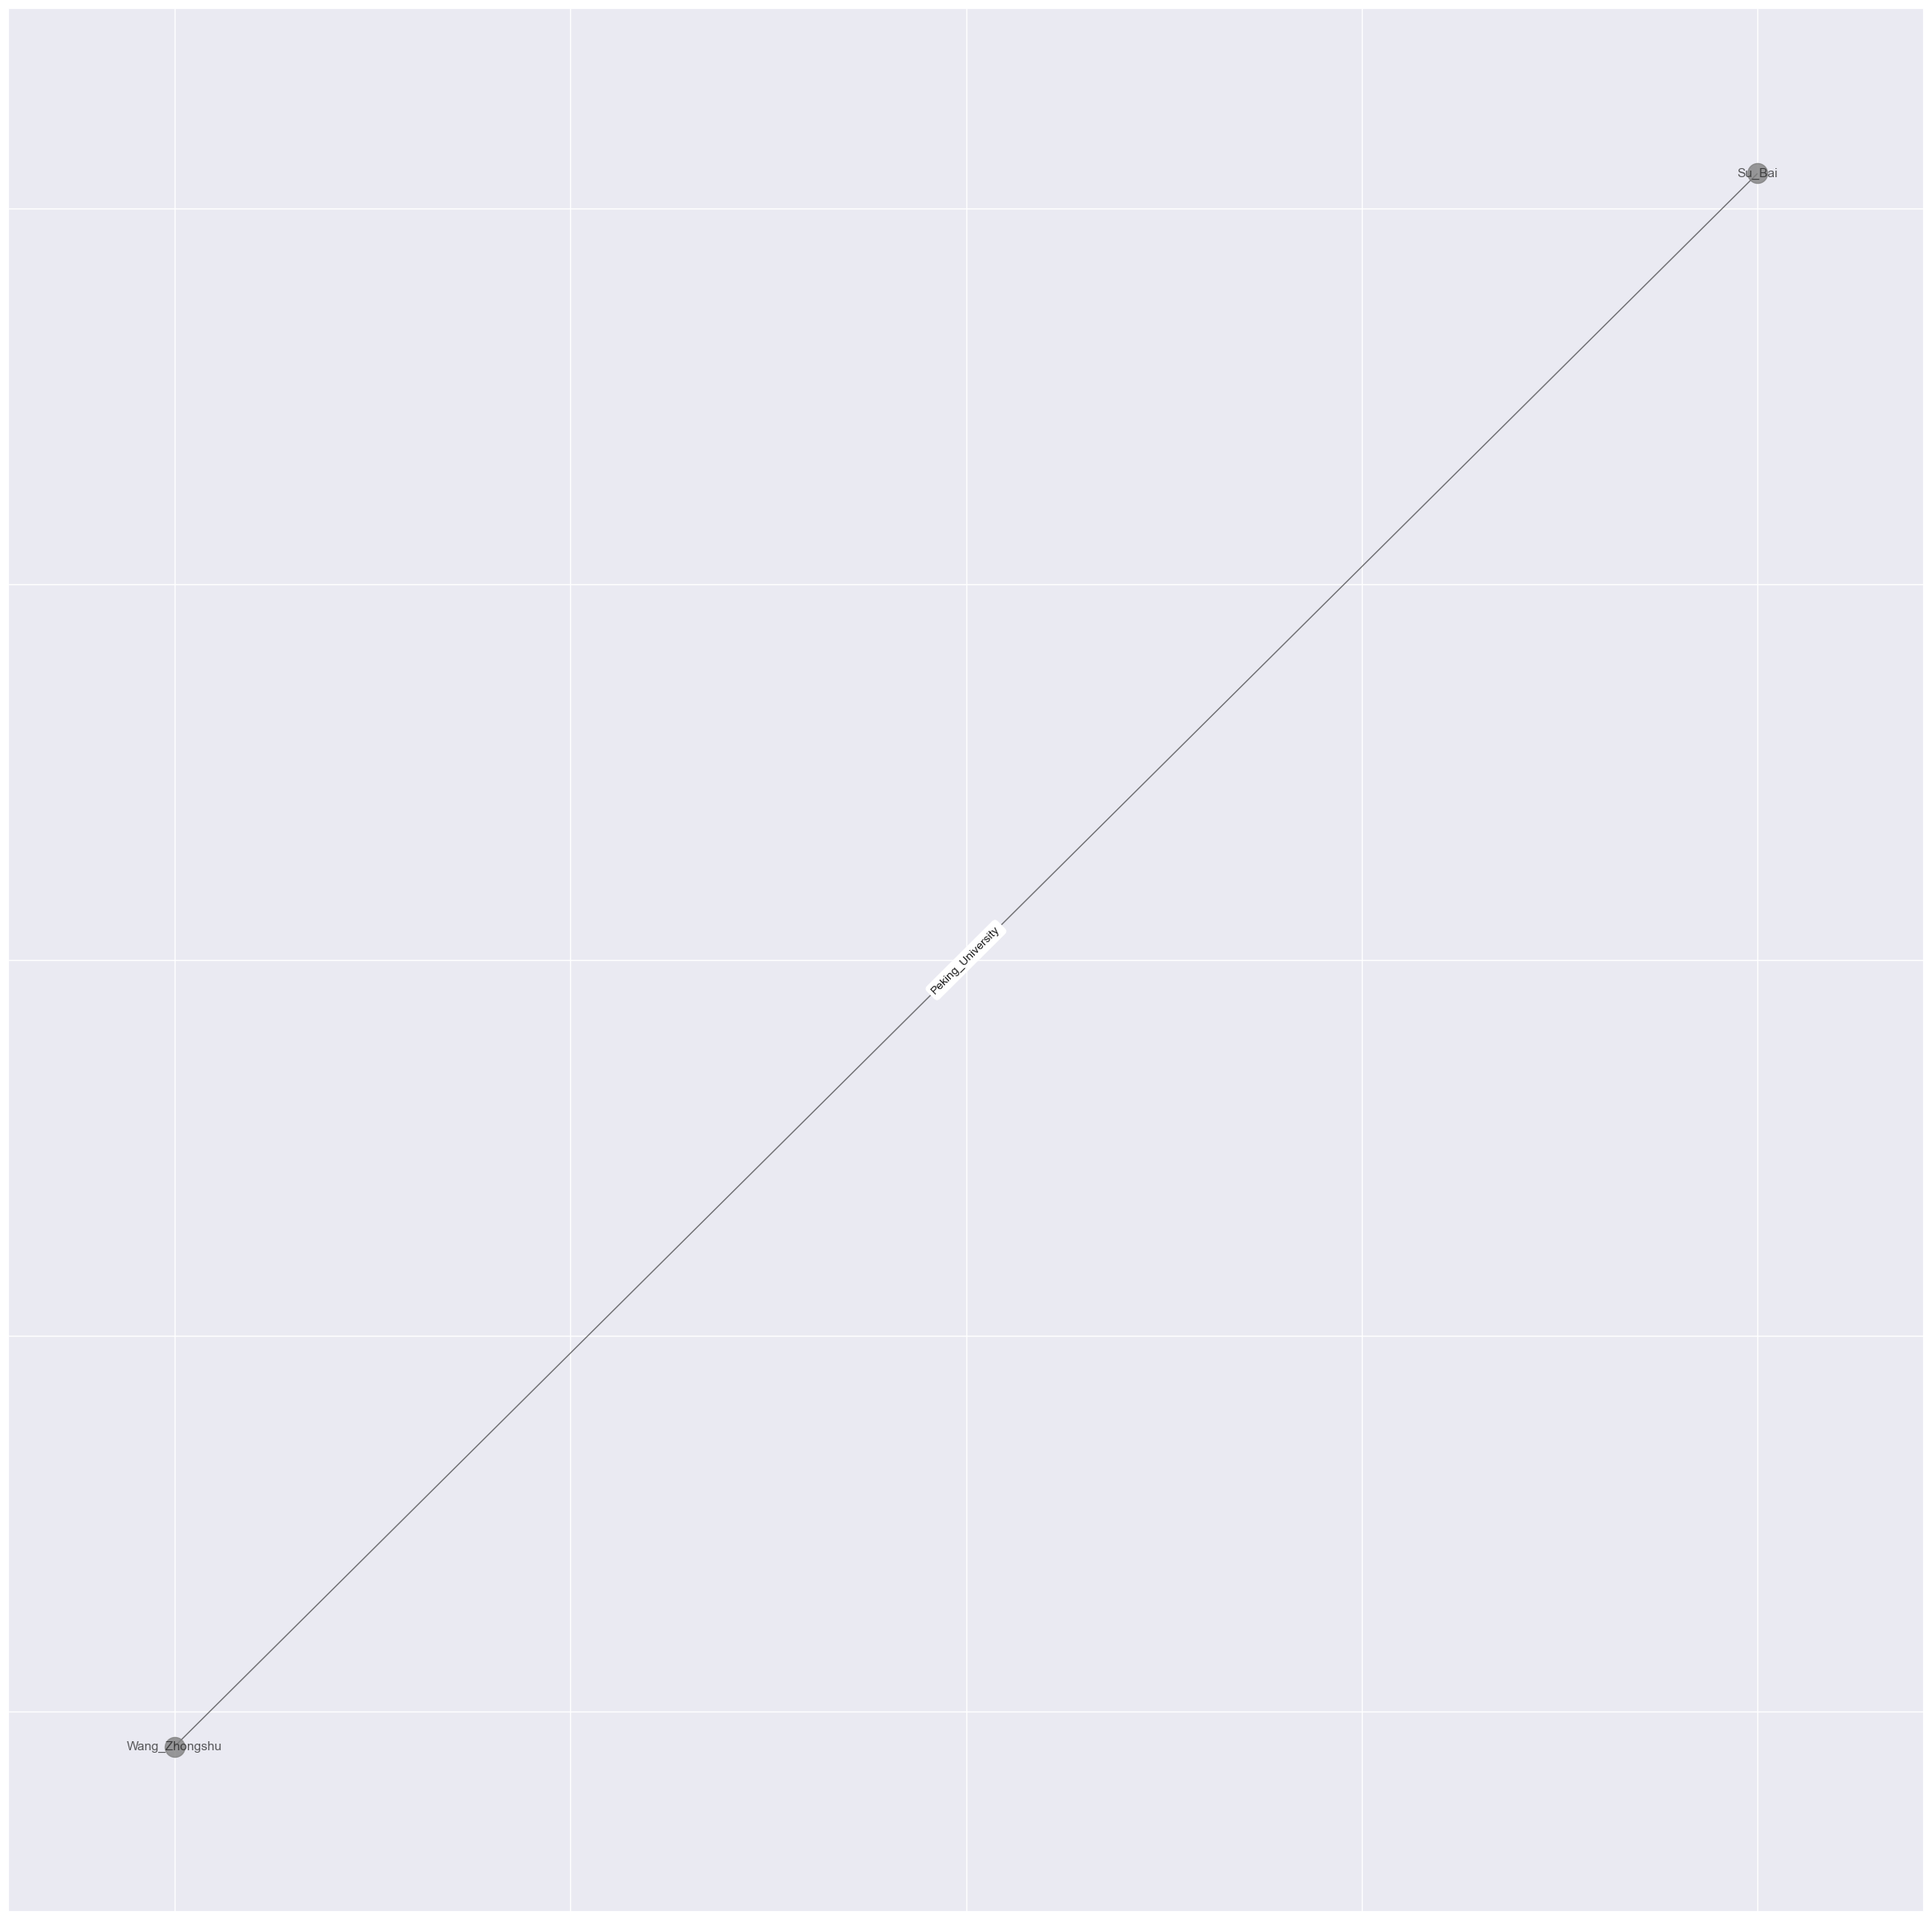

In [76]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(g, k=1)

labels = {e: u.get_edge_data(e[0], e[1])["organisation"] for e in u.edges()}

cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_color=cp, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=11)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)



plt.show()


## Explorer le graphe des organisations (relation Alma Mater)

In [77]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'subject_uri': 'Alice_Kober',
   'r_property': 'almaMater',
   'target': 'Columbia_University',
   'YBegin': 1923,
   'YEnd': 1934,
   'BirthYear': 1906,
   'periode': '1901_2021'},
  {'subject_uri': 'Alice_Kober',
   'r_property': 'almaMater',
   'target': 'Hunter_College',
   'YBegin': 1923,
   'YEnd': 1934,
   'BirthYear': 1906,
   'periode': '1901_2021'}],
 [{'subject_uri': 'Alice_Kober',
   'r_property': 'almaMater',
   'target': 'Columbia_University',
   'YBegin': 1923,
   'YEnd': 1934,
   'BirthYear': 1906,
   'periode': '1901_2021'},
  {'subject_uri': 'Alice_Kober',
   'r_property': 'almaMater',
   'target': 'Doctor_of_Philosophy',
   'YBegin': 1923,
   'YEnd': 1934,
   'BirthYear': 1906,
   'periode': '1901_2021'}]]

In [78]:
l = []
for i in pairs_o:
    if i[0]['r_property'] == 'almaMater' or  i[1]['r_property'] == 'almaMater':
        l.append(tuple((i[0]['target'],i[1]['target'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}", 
                                                              'personne': i[0]['subject_uri'] })))
len(l), l[:3]        

(173,
 [('Columbia_University',
   'Hunter_College',
   {'relationship': 'almaMater_almaMater', 'personne': 'Alice_Kober'}),
  ('Columbia_University',
   'Doctor_of_Philosophy',
   {'relationship': 'almaMater_almaMater', 'personne': 'Alice_Kober'}),
  ('Doctor_of_Philosophy',
   'Hunter_College',
   {'relationship': 'almaMater_almaMater', 'personne': 'Alice_Kober'})])

In [79]:
### Graphe des organisation, liens AlmaMater

amO=nx.Graph()

In [80]:
amO.add_edges_from(l)

In [81]:
### Principales caractéristiques de ce graphe

amO.is_multigraph(),nx.is_connected(amO) , amO.number_of_nodes(), amO.number_of_edges(), nx.density(amO)


(False, False, 117, 159, 0.023430592396109638)

In [82]:
nodes = list(amO.nodes.data())
nodes[:5]

[('Columbia_University', {}),
 ('Hunter_College', {}),
 ('Doctor_of_Philosophy', {}),
 ('University_of_Glasgow', {}),
 ('University_of_London', {})]

In [83]:
edges = list(amO.edges.data())
edges[:5]

[('Columbia_University',
  'Hunter_College',
  {'relationship': 'almaMater_almaMater', 'personne': 'Alice_Kober'}),
 ('Columbia_University',
  'Doctor_of_Philosophy',
  {'relationship': 'almaMater_almaMater', 'personne': 'Alice_Kober'}),
 ('Columbia_University',
  'National_Museum_of_Natural_History',
  {'relationship': 'almaMater_institution', 'personne': 'Betty_Meggers'}),
 ('Columbia_University',
  'Smithsonian_Institution',
  {'relationship': 'almaMater_institution', 'personne': 'Betty_Meggers'}),
 ('Columbia_University',
  'University_of_Michigan',
  {'relationship': 'almaMater_almaMater', 'personne': 'Betty_Meggers'})]

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [84]:
components = nx.connected_components(amO);
components_l = [len(c) for c in sorted(nx.connected_components(amO), key=len, reverse=True)]
len(components_l), components_l[:5]

(18, [71, 5, 4, 4, 4])

In [85]:
largest_cc = max(nx.connected_components(amO), key=len); type(largest_cc)

set

In [86]:
S = amO.subgraph(largest_cc).copy()
type(S)


networkx.classes.graph.Graph

In [87]:
### Principales caractéristiques de ce graphe

S.is_multigraph(),nx.is_connected(S) , S.number_of_nodes(), S.number_of_edges(), nx.density(S)


(False, True, 71, 124, 0.049899396378269616)

### Centralité de degré

Documentation: [degree_centrality(G)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality)

In [88]:
# On construit ici le dictionnaire selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(S)])

In [89]:
nx.set_node_attributes(amO, degree)
print(list(amO.nodes.data())[:3])

[('Columbia_University', {'degree': 8}), ('Hunter_College', {'degree': 2}), ('Doctor_of_Philosophy', {'degree': 2})]


### Centralité de proximité

Compute [closeness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) for nodes.


In [90]:
closeness = nx.closeness_centrality(amO)

In [91]:
nx.set_node_attributes(amO, closeness, 'closeness')

### Centralité d'intermédiarité

[Betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)

In [92]:
betweenness = nx.betweenness_centrality(amO)

In [93]:
nx.set_node_attributes(amO, betweenness, 'betweenness')


In [94]:
### Exporter les attributs vers un DataFrame afin de les explorer
export = pd.DataFrame(amO.nodes.data(), columns = ['id', 'attributes'])
#export = export.set_index('id')
export.head()

,id,attributes
0,Columbia_University,"{'degree': 8, 'closeness': 0.2001961104755679,..."
1,Hunter_College,"{'degree': 2, 'closeness': 0.15140279322704236..."
2,Doctor_of_Philosophy,"{'degree': 2, 'closeness': 0.15140279322704236..."
3,University_of_Glasgow,"{'degree': 2, 'closeness': 0.17171292402579197..."
4,University_of_London,"{'degree': 13, 'closeness': 0.2373111197210383..."


In [95]:
### Décomposer le champs attributs en colonnes

attributes = pd.json_normalize(export.attributes)

## Retour à affichage des décimales par défaut:
pd.options.display.float_format = '{: }'.format 

round(attributes, 4)

,degree,closeness,betweenness
0,8.0,0.2002,0.0409
1,2.0,0.1514,0.0
2,2.0,0.1514,0.0
3,2.0,0.1717,0.0
4,13.0,0.2373,0.1183
...,...,...,...
112,NaN,0.0086,0.0
113,NaN,0.0086,0.0
114,NaN,0.0086,0.0
115,2.0,0.1525,0.0


In [96]:
### appliquer au DataFrame et supprimer la colonne attributes
# en même temps mettre le nom en index
export = export.join(attributes)
export = export.drop(columns=['attributes'],axis=1)
export.head()

,id,degree,closeness,betweenness
0,Columbia_University,8.0,0.2001961104755679,0.04085600057114299
1,Hunter_College,2.0,0.15140279322704236,0.0
2,Doctor_of_Philosophy,2.0,0.15140279322704236,0.0
3,University_of_Glasgow,2.0,0.17171292402579197,0.0
4,University_of_London,13.0,0.23731111972103835,0.11829406725208816


In [97]:
round(export.sort_values(by=['degree'], ascending=False),3)

,id,degree,closeness,betweenness
9,University_of_Michigan,18.0,0.239,0.145
4,University_of_London,13.0,0.237,0.118
22,University_of_Cape_Town,11.0,0.208,0.057
10,University_of_Pennsylvania,10.0,0.202,0.06
34,University_of_Chicago,9.0,0.206,0.031
...,...,...,...,...
110,University_of_Bucharest,NaN,0.009,0.0
111,Peking_University,NaN,0.009,0.0
112,Zhejiang_University,NaN,0.009,0.0
113,Leiden_University,NaN,0.009,0.0


In [98]:
export['degree'].describe()

count                 71.0
mean     3.492957746478873
std      3.129916655378815
min                    1.0
25%                    2.0
50%                    2.0
75%                    4.0
max                   18.0
Name: degree, dtype: float64

(1.0, 18.0)

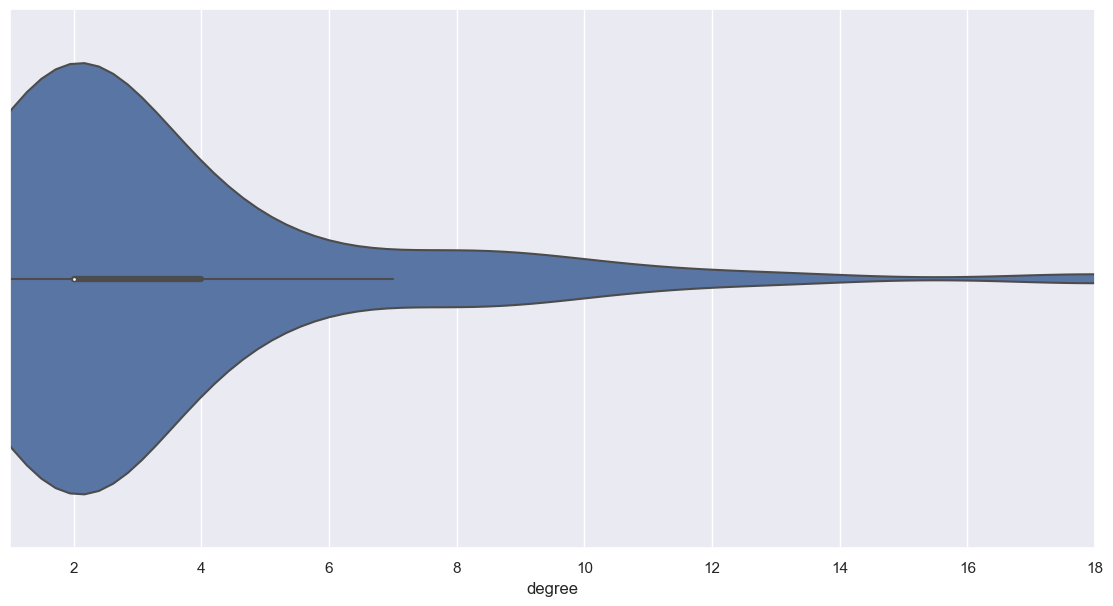

In [99]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(14, 7)})

a = export['degree'].dropna()
lim_left=min(a)
lim_right=max(a)





ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=lim_left, right=lim_right)


In [100]:
kamo = nx.k_core(amO, k=1)

In [101]:
### Principales caractéristiques de ce graphe

kamo.is_multigraph(),nx.is_connected(kamo) , kamo.number_of_nodes(), kamo.number_of_edges(), nx.density(kamo)


(False, False, 117, 159, 0.023430592396109638)

In [102]:
components = nx.connected_components(kamo);
components_l = [len(c) for c in sorted(nx.connected_components(kamo), key=len, reverse=True)]
len(components_l), components_l[:5]

(18, [71, 5, 4, 4, 4])

In [103]:
largest_cc = max(nx.connected_components(kamo), key=len)

In [104]:
S = kamo.subgraph(largest_cc).copy()
type(S)


networkx.classes.graph.Graph

### Représenter le graphe

In [105]:
### Principales caractéristiques de ce graphe

u = S
u.is_multigraph(), nx.is_connected(u), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


(False, True, 71, 124, 0.049899396378269616)

In [106]:
list(u.nodes.data())[1:3]

[('Hunter_College',
  {'degree': 2, 'closeness': 0.15140279322704236, 'betweenness': 0.0}),
 ('Doctor_of_Philosophy',
  {'degree': 2, 'closeness': 0.15140279322704236, 'betweenness': 0.0})]

In [107]:
labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] > 15:
        labels[i[0]]=i[0] 
list(labels.items())[:3]

[('University_of_Michigan', 'University_of_Michigan')]

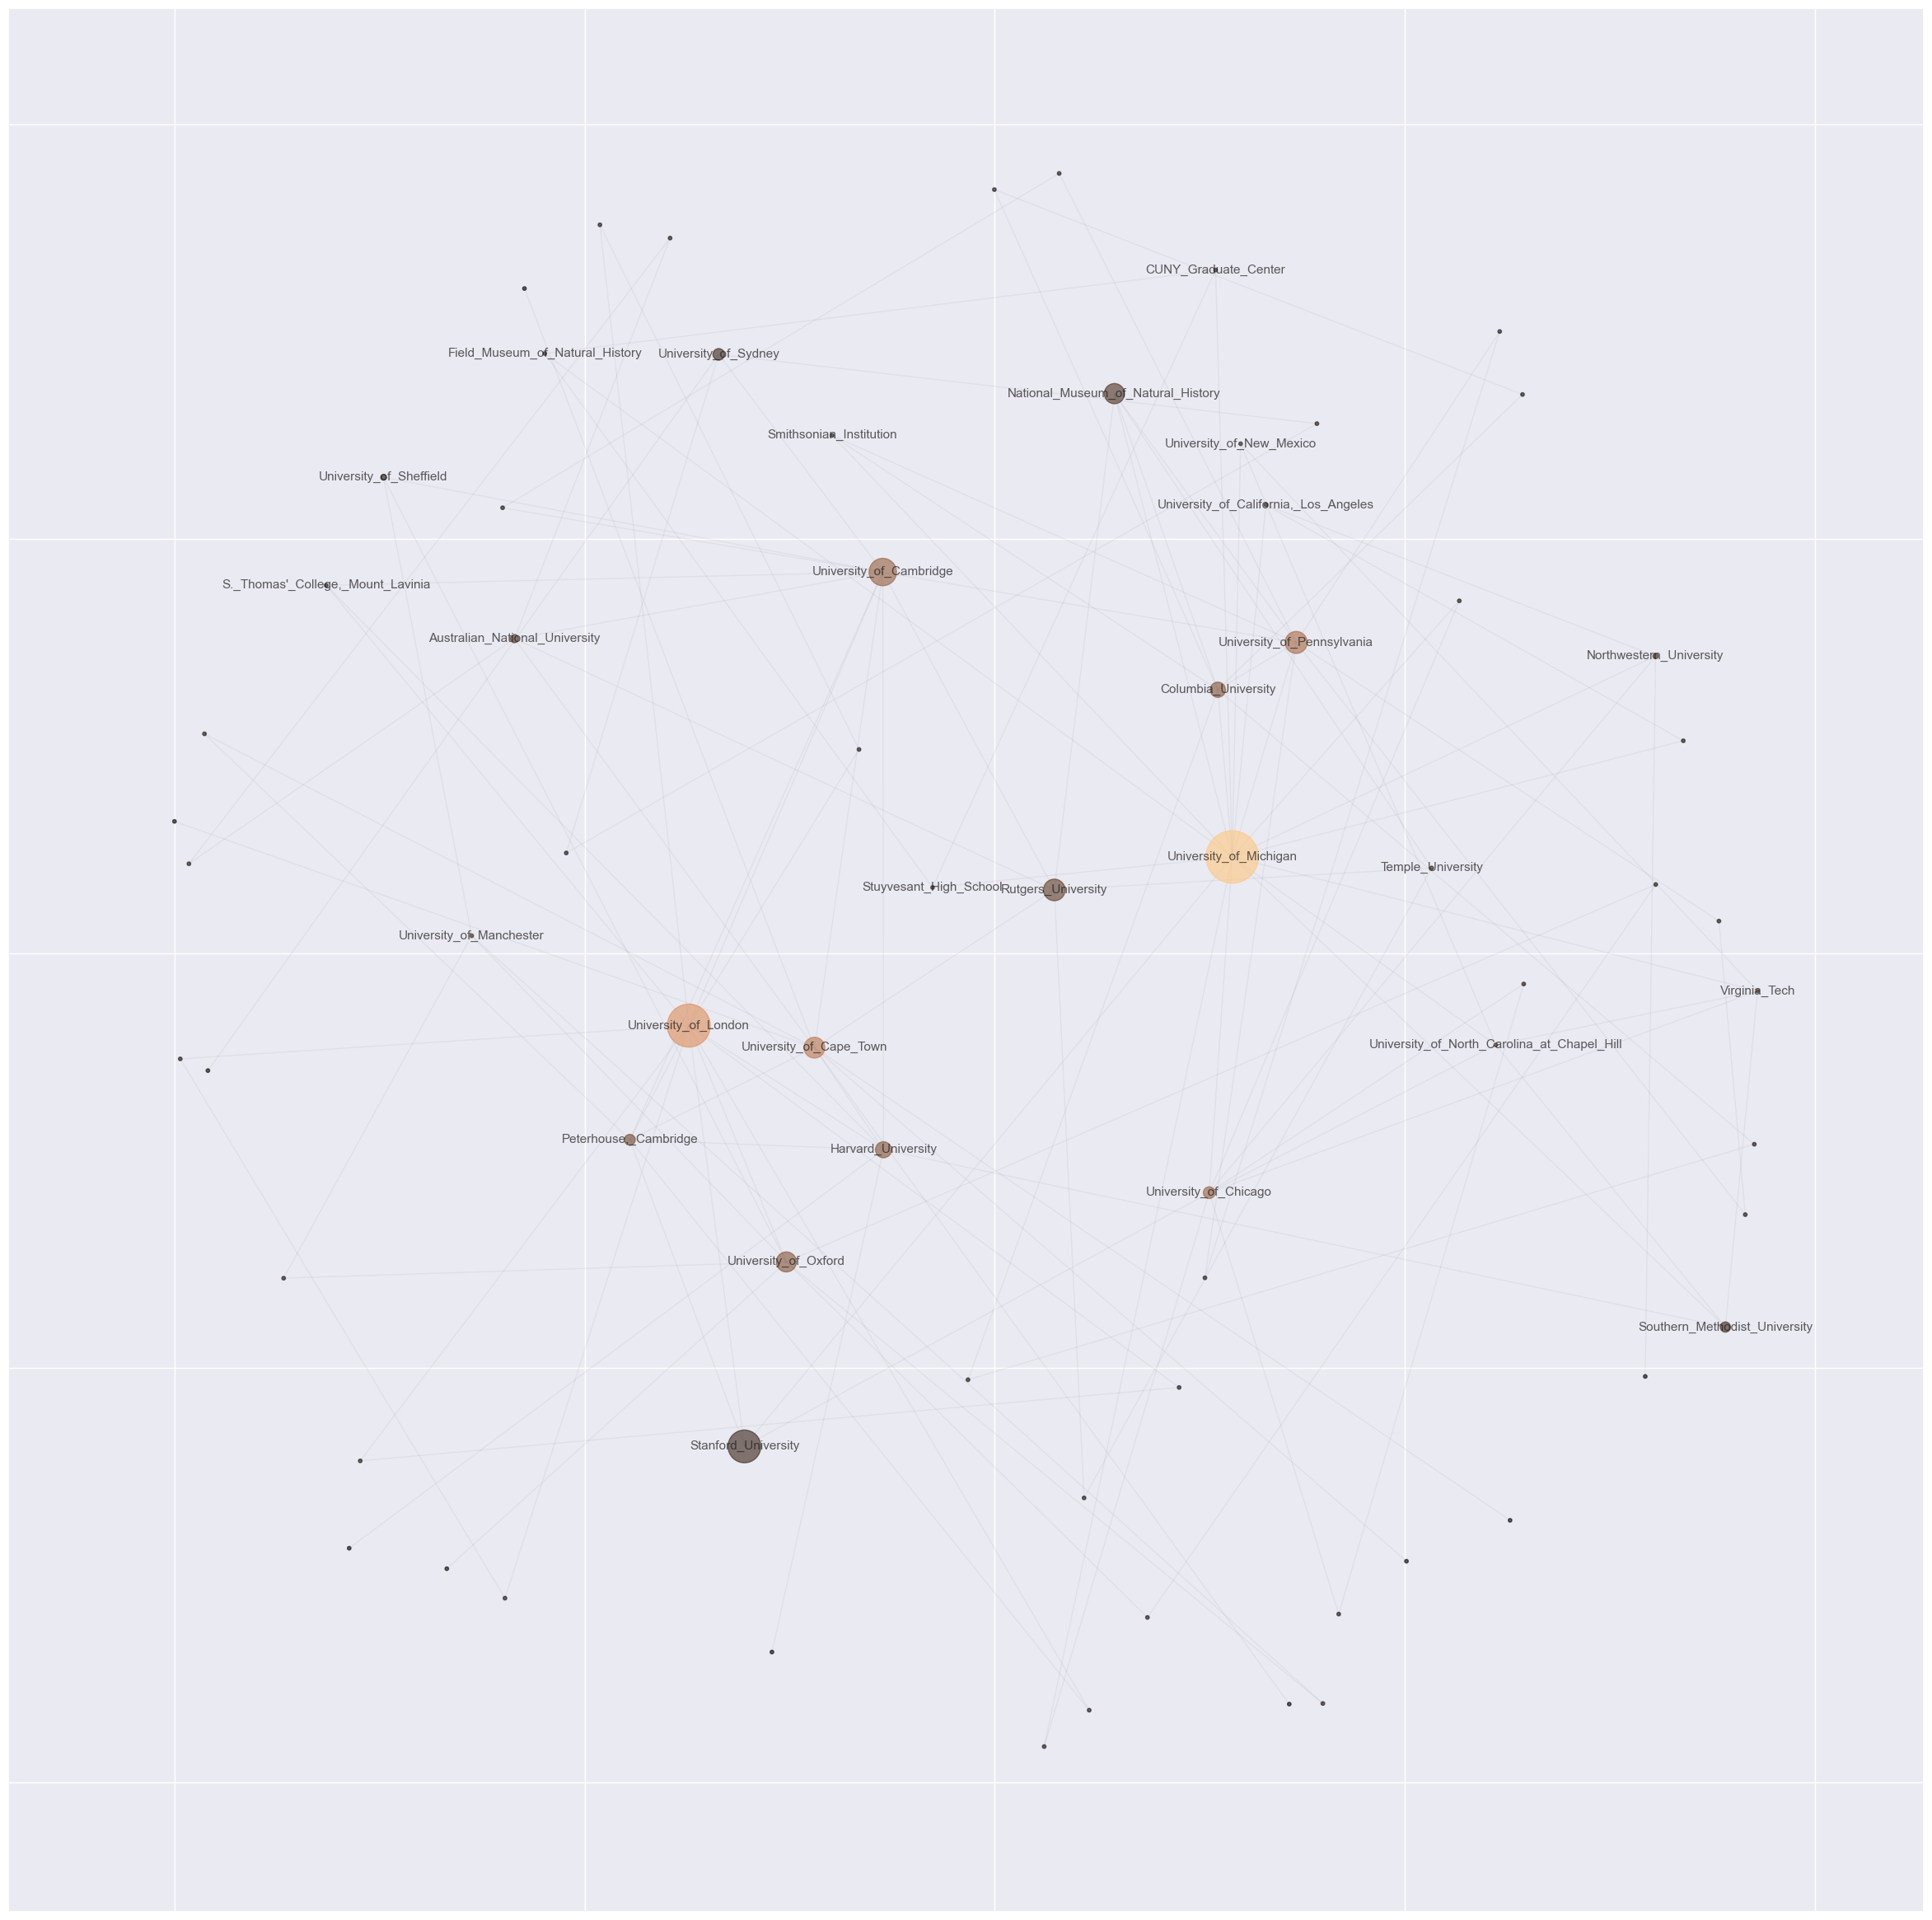

In [109]:

plt.figure(figsize = (30,30))


g = u

pos = nx.spring_layout(g, k=1)

labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] > 2:
        labels[i[0]]=i[0] 

node_color = [i[1]['degree'] for i in list(u.nodes.data())]

### Adapter la taille des attribut à l'affichage
node_sizes = [i[1]['betweenness']**2 * 100000 + 10 for i in list(u.nodes.data())]


cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_size=node_sizes, node_color=node_color, 
                      cmap='copper', alpha=0.6)
nx.draw_networkx_edges(g, pos, alpha=0.05) 
nx.draw_networkx_labels(g, pos, labels=labels,  alpha=0.7, font_size=11)


f = 'pictures/universites.svg'

plt.savefig(f, format="svg")

plt.show()
